# Investigation

The API homepage lets you download CSVs of historical forecast and actual CI. These are (presumably) the final forecast values for the given time window. Here I check the forecast error.

In [1]:
%matplotlib inline

import os
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scrape.files import get_data_files
from scrape.graph import _ftime

plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 250

# Get data files 2022-23
files = get_data_files("data/samples", extension=".csv")

df = pd.concat([pd.read_csv(fp, index_col=0) for fp in sorted(files)])

# Drop duplicates from overlapping dates
df = df[~df.index.duplicated(keep="last")]

df.index = pd.to_datetime(df.index)

In [2]:
df["error"] = df["Forecast Carbon Intensity (gCO2/kWh)"].sub(df["Actual Carbon Intensity (gCO2/kWh)"])
df["percentage error"] = 100. * df["error"].div(df["Actual Carbon Intensity (gCO2/kWh)"])
df.tail()

,Actual Carbon Intensity (gCO2/kWh),Forecast Carbon Intensity (gCO2/kWh),Index,error,percentage error
Datetime (UTC),,,,,
2023-03-30 22:00:00+00:00,81.0,139,low,58.0,71.604938
2023-03-30 22:30:00+00:00,77.0,129,low,52.0,67.532468
2023-03-30 23:00:00+00:00,78.0,105,low,27.0,34.615385
2023-03-30 23:30:00+00:00,77.0,85,low,8.0,10.389610
2023-03-31 00:00:00+00:00,82.0,81,low,-1.0,-1.219512


2017: mean 9.176311999523838, std 13.679474837027618
2018: mean 10.822421092169625, std 34.67726398646401
2019: mean 5.908749639934832, std 56.70681449783952
2020: mean 6.315442144994107, std 9.279700400943442
2021: mean 5.450166185300275, std 8.016490329398568
2022: mean 6.401842465289679, std 10.512159106586562
2023: mean 7.907825272072335, std 12.748422111917812


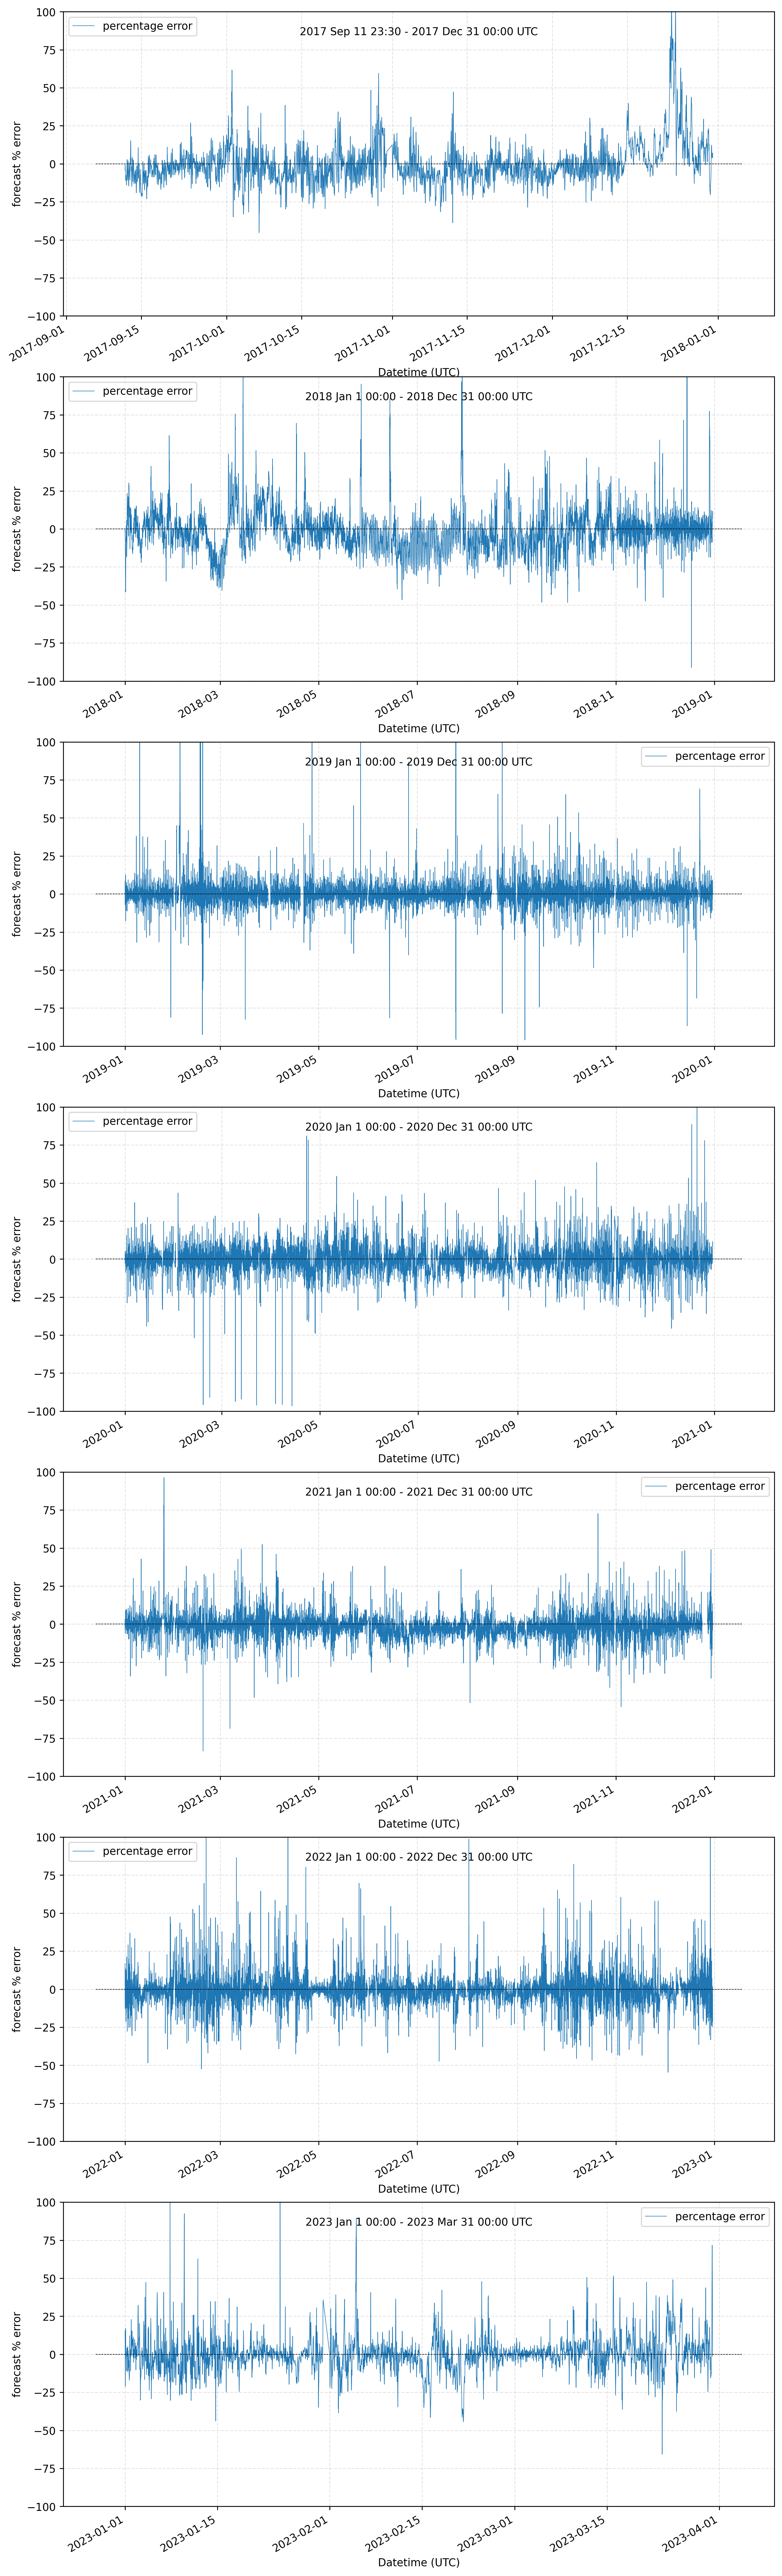

In [3]:
# Get unique years from the index and plot by year
years = list({dt.year: "" for dt in df.index}.keys())

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 250

fig, axes = plt.subplots(len(years), 1, sharex=False, sharey="col")
for ix, ax in enumerate(axes):
    dates = [d for d in df.index if d.year == years[ix]]
    df.loc[dates, ["percentage error"]].plot(ax=ax, linewidth=0.5)
    
    title = f"{_ftime(dates[0])} - {_ftime(dates[-1])} UTC"
    ax.text(0.5, 0.95, title, horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
    
#     ax.set_title()
    ax.set_ylabel("forecast % error")
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.hlines(
        0.0,
        ax.get_xlim()[0],
        ax.get_xlim()[-1],
        color="k",
        linestyle="--",
        linewidth=0.5,
    )
    
    # The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
    year_mean = df.loc[dates, ["percentage error"]].abs().mean()
    year_std = df.loc[dates, ["percentage error"]].std()
    print(f"{dates[0].year}: mean {float(year_mean)}, std {float(year_std)}")

ax.set_ylim(-100,100)
    
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 250

ax = df.plot(use_index=True, y="percentage error", linewidth=0.5, label=r"percentage error")

ax.set_ylim(-150,150)
ax.set_title(f"{_ftime(df.index[0])} - {_ftime(df.index[-1])} UTC")
ax.set_ylabel("forecast % error")
ax.grid("on", linestyle="--", alpha=0.33)
ax.hlines(
    0.0,
    ax.get_xlim()[0],
    ax.get_xlim()[-1],
    color="k",
    linestyle="--",
    linewidth=0.5,
)

xticks = ax.get_xticks()
xlabels = ax.get_xticklabels()

ax.set_xticks(xticks, xlabels, rotation=90, ha="center")

locator = mdates.MonthLocator(interval=1)  # every month
locator = mdates.YearLocator()
fmt = mdates.DateFormatter("%Y-%b")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

fig = plt.gcf()
fig.suptitle(f"Percentage national forecast error, {len(df.index)} half-hour windows")

In [ ]:
# The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
print(df["percentage error"].abs().mean(), df["percentage error"].std())

In [ ]:
ax = df["error"].hist(bins=100)
ax.grid("on", linestyle="--", alpha=0.33)

from scipy.stats import t

m = df["error"].mean()
scale = df["error"].std()
dof = len(df["error"]) - 1

# random sample
samp = t.rvs(df=dof, loc=m, scale=scale, size=100000)
param = t.fit(samp)

# x = np.linspace(-100,100,10000)

x = np.arange(-100, 100, 0.1)
pdf_fitted = t.pdf(x, df=param[0], loc=param[1], scale=param[2])

ax.plot(x, pdf_fitted)

# y = stats.norm.pdf(x, df["error"].mean(), df["error"].std()) * 90000
# # y = stats.t.pdf(x, df["error"].mean(), df["error"].std())

# dist = stats.t(df["error"].mean(), df["error"].std())

# values = [value for value in range(-100, 100)]
# probabilities = [dist.pdf(value) * 70000 for value in values]

# ax.plot(values,probabilities)

In [ ]:
df_ci = pd.read_csv("data/artifacts/ci_index_numerical_bands.csv", index_col=0, header=[0,1])

cols = [(title, metric) for title in ["moderate - very low", "high - low", "very high - moderate"] for metric in ["difference", "percentage"]]

df_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols), index=df_ci.index)

for ix, row in df_ci.iterrows():
    diff = row["moderate"]["from"] - row["very low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "percentage"]] = 100. * diff / row["moderate"]["from"]
    
    diff = row["high"]["from"] - row["low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["high - low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["high - low", "percentage"]] = 100. * diff / row["high"]["from"]
    
    diff = row["very high"]["from"] - row["moderate"]["to"]
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "percentage"]] = 100. * diff / row["very high"]["from"]

In [ ]:
df_ci

In [ ]:
df_comp